In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import time
# from scipy.stats import gaussian_kde
# import scipy.stats as stats

In [2]:
from dataset import CO2_synthetic_dataset
from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset
# from sequence_dataset import SequenceDataset, train_test_split

In [3]:
import kgml_lib

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [5]:
# define functions from kgml_lib
Z_norm = kgml_lib.Z_norm 
Z_norm_reverse = kgml_lib.Z_norm_reverse
get_gpu_memory = kgml_lib.get_gpu_memory

In [6]:
root_dir = 'E:/PyKGML/deposit_code_v2/'
data_path = root_dir +  'processed_data/'
output_path = root_dir + 'test_results/'

input_data = 'recotest_data_scaled_v4_100sample.sav'
sample_index_file = "traindataset_split_year_v1.sav"

pretrained_model = "recotest_v11_exp4.sav_step1"
output_model = "recotest_v11_exp4_sample.sav_step2"
synthetic_data = "sys_data2.sav"

dataset = CO2_synthetic_dataset(data_path, input_data, output_path, sample_index_file)
dataset.load_step2_data()

dataset.prepare_step2_data()

torch.Size([6570, 100, 19]) torch.Size([6570, 100, 3]) torch.Size([18, 100, 1])
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC']


In [7]:
X = dataset.X  #[365*18, 100, 19]
X = torch.transpose(X,1, 0) #[100, 365*18, 19]

Y1 = dataset.Y1 #[365*18, 100, 3]
Y1 = torch.transpose(Y1,1, 0) #[100, 365*18, 3]

Y2 = dataset.Y2 #[18, 100, 1]
Y2 = torch.transpose(Y2,1, 0)

y_scaler = dataset.Y1_scaler


In [8]:
x_scaler= dataset.X_scaler
GPP_scaler = x_scaler[8]

In [9]:
GPP_scaler

array([2.8892129 , 5.75792418])

In [10]:
def Z_norm_reverse(X,Xscaler,units_convert=1.0):
    return (X*Xscaler[1]+Xscaler[0])*units_convert

def Z_norm_with_scaler(X,Xscaler):
    return (X-Xscaler[0])/Xscaler[1]

In [10]:
input_features = ['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 
                  'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC']
output_features = ['Ra','Rh','NEE']

In [11]:
from customize_loss import CarbonFluxLossCompiler

In [12]:
script_config = {
    'parameters': {
        'GPP_idx': 8,
        'Ra_idx': 0,
        'Rh_idx': 1,
        'NEE_idx': 2,
        'tol_MB': 0.01,
    },
    
    'variables': {
        'GPP': 'batch_x[:, :, GPP_idx]',
        'Ra_pred': 'y_pred[:, :, Ra_idx]',
        'Rh_pred': 'y_pred[:, :, Rh_idx]',
        'NEE_pred': 'y_pred[:, :, NEE_idx]',
        'Ra_true': 'y_true[:, :, Ra_idx]',
        'Rh_true': 'y_true[:, :, Rh_idx]',
        'NEE_true': 'y_true[:, :, NEE_idx]',
        },
    
    'loss_fomula': {
        'Reco': 'Ra_pred + Rh_pred',
        'loss1': 'mean((Ra_pred - Ra_true)**2 + (Rh_pred - Rh_true)**2 + (NEE_pred - NEE_true)**2)',
        'loss2': 'abs(GPP - Reco + NEE_pred) - tol_MB * abs(Reco)',
        'loss': 'mean(loss1 + loss2)',}
    }

In [26]:
script_config = {
    'parameters': {
        'GPP_idx': 8,
        'Ra_idx': 0,
        'Rh_idx': 1,
        'NEE_idx': 2,
        'tol_MB': 0.01,
        'GPP_scaler': GPP_scaler,
        'y_scaler':y_scaler},
    
    'variables': {
        'GPP': 'Z_norm_reverse(batch_x[:, :, GPP_idx], GPP_scaler)',
        'Ra_pred': 'Z_norm_reverse(y_pred[:, :, Ra_idx], y_scaler[Ra_idx])',
        'Rh_pred': 'Z_norm_reverse(y_pred[:, :, Rh_idx], y_scaler[Rh_idx])',
        'NEE_pred': 'Z_norm_reverse(y_pred[:, :, NEE_idx], y_scaler[NEE_idx])',
        'Ra_true': 'Z_norm_reverse(y_true[:, :, Ra_idx], y_scaler[Ra_idx])',
        'Rh_true': 'Z_norm_reverse(y_true[:, :, Rh_idx], y_scaler[Rh_idx])',
        'NEE_true': 'Z_norm_reverse(y_true[:, :, NEE_idx], y_scaler[NEE_idx])',
        },
    
    'loss_fomula': {
        'Reco': 'Ra_pred + Rh_pred',
        'loss1': 'mean((Ra_pred - Ra_true)**2 + (Rh_pred - Rh_true)**2 + (NEE_pred - NEE_true)**2)',
        'loss2': 'abs(GPP - Reco + NEE_pred) - tol_MB * abs(Reco)',
        'loss': 'mean(loss1 + loss2)',}
    }

In [12]:
script_config = {
    'parameters': {
        'GPP_idx': 8,
        'Ra_idx': 0,
        'Rh_idx': 1,
        'NEE_idx': 2,
        'tol_MB': 0.01,
        'lamda': [0.1, 0.09],
        'aaa_scaler': GPP_scaler,
        'ccc_scaler':y_scaler},
    
    'variables': {
        'GPP': 'Z_norm_reverse(batch_x[:, :, GPP_idx], aaa_scaler)',
        'Ra_pred': 'Z_norm_reverse(y_pred[:, :, Ra_idx], ccc_scaler[Ra_idx])',
        'Rh_pred': 'Z_norm_reverse(y_pred[:, :, Rh_idx], ccc_scaler[Rh_idx])',
        'NEE_pred': 'Z_norm_reverse(y_pred[:, :, NEE_idx], ccc_scaler[NEE_idx])',
        'Ra_true': 'Z_norm_reverse(y_true[:, :, Ra_idx], ccc_scaler[Ra_idx])',
        'Rh_true': 'Z_norm_reverse(y_true[:, :, Rh_idx], ccc_scaler[Rh_idx])',
        'NEE_true': 'Z_norm_reverse(y_true[:, :, NEE_idx], ccc_scaler[NEE_idx])',
        },
    
    'loss_fomula': {
        'Reco': 'Ra_pred + Rh_pred',
        'loss1': 'mean((Ra_pred - Ra_true)**2 + (Rh_pred - Rh_true)**2 + (NEE_pred - NEE_true)**2)',
        'loss2': 'abs(GPP - Reco + NEE_pred) - tol_MB * abs(Reco)',
        'loss': 'mean(lamda[0]*loss1 + lamda[1]*loss2)',}
    }

In [13]:
# Create the compiler
compiler = CarbonFluxLossCompiler(script_config)

# Print the created loss class code
print("Generated CarbonFluxLoss:")
print(compiler.class_code)

生成的CarbonFluxLoss类代码:
import torch
import torch.nn as nn

class CarbonFluxLoss(nn.Module):
    def __init__(self, GPP_idx=8, Ra_idx=0, Rh_idx=1, NEE_idx=2, tol_MB=0.01, lamda=[0.1, 0.09], aaa_scaler=[2.8892129010294383, 5.757924175519595], ccc_scaler=[[-1.3584023714065552, 2.5833351612091064], [-0.9747186899185181, 0.8566842675209045], [-0.5235359072685242, 2.9942545890808105]]):
        super().__init__()
        self.GPP_idx = GPP_idx
        self.Ra_idx = Ra_idx
        self.Rh_idx = Rh_idx
        self.NEE_idx = NEE_idx
        self.tol_MB = tol_MB
        self.lamda = lamda
        self.aaa_scaler = aaa_scaler
        self.ccc_scaler = ccc_scaler

    def forward(self, y_pred, y_true, batch_x):
        # Copy parameters to local variables
        GPP_idx = self.GPP_idx
        Ra_idx = self.Ra_idx
        Rh_idx = self.Rh_idx
        NEE_idx = self.NEE_idx
        tol_MB = self.tol_MB
        lamda = self.lamda
        aaa_scaler = self.aaa_scaler
        ccc_scaler = self.ccc_sca

In [28]:
# Create loss class
CarbonFluxLoss = compiler.generate_class()

# the loss function with default values
loss_fn = CarbonFluxLoss()

# loss_fn = CarbonFluxLoss(
#     GPP_idx=8,
#     Ra_idx=0,
#     Rh_idx=1,
#     NEE_idx=2,
#     tol_MB=0.01,
#     GPP_scaler=GPP_scaler,
#     y_scaler=y_scaler
# )

In [15]:
num_input_features = 19
num_output_features = 3

input_dim = num_input_features
hidden_dim = 128
num_layers = 3
output_dim = num_output_features
dropout=0.2

In [16]:
# Choose one of the models below:
#model = LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)
# model = GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)

# model = EnhancedGRUModel(input_dim, hidden_dim, num_layers, output_dim)

# model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim)

In [17]:
total_years = 18
# days_per_year = 365
# total_days = total_years * days_per_year
# num_sites = X.shape[0] #100

batch_size=64

model.train_test_split(X, Y1, total_years, batch_size, split_method=1)

In [18]:
learning_rate = 0.001
step_size = 20
max_epoch = 60
loss_function = loss_fn #nn.L1Loss() # The loss function

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/60 | LR: 0.001000, Train Loss: 1.8412, Test Loss: 1.4036
Epoch 2/60 | LR: 0.001000, Train Loss: 1.2169, Test Loss: 0.9378
Epoch 3/60 | LR: 0.001000, Train Loss: 0.7724, Test Loss: 0.6995
Epoch 4/60 | LR: 0.001000, Train Loss: 0.6688, Test Loss: 0.6482
Epoch 5/60 | LR: 0.001000, Train Loss: 0.6055, Test Loss: 0.5925
Epoch 6/60 | LR: 0.001000, Train Loss: 0.5712, Test Loss: 0.5602
Epoch 7/60 | LR: 0.001000, Train Loss: 0.5449, Test Loss: 0.5451
Epoch 8/60 | LR: 0.001000, Train Loss: 0.5329, Test Loss: 0.5320
Epoch 9/60 | LR: 0.001000, Train Loss: 0.5140, Test Loss: 0.5155
Epoch 10/60 | LR: 0.001000, Train Loss: 0.5033, Test Loss: 0.5051
Epoch 11/60 | LR: 0.001000, Train Loss: 0.4922, Test Loss: 0.4999
Epoch 12/60 | LR: 0.001000, Train Loss: 0.4862, Test Loss: 0.4925
Epoch 13/60 | LR: 0.001000, Train Loss: 0.4791, Test Loss: 0.4868
Epoch 14/60 | LR: 0.001000, Train Loss: 0.4705, Test Loss: 0.4824
Epoch 15/60 | LR: 0.001000, Train Loss: 0.4668, Test Loss: 0.4793
Epoch 16/60 | LR: 0

In [19]:
model.test()

Test Loss: 2.3788


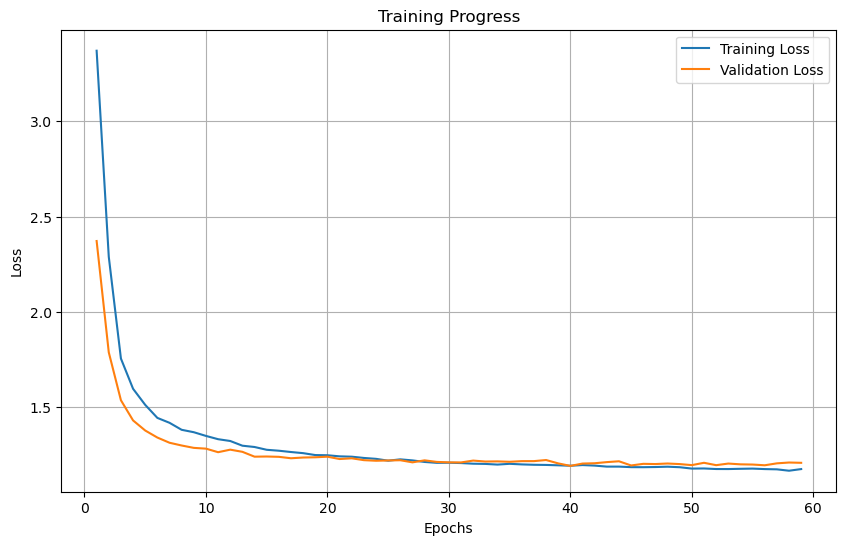

In [20]:
model.plot_training_curves()

In [21]:
output_feature_name = ['Ra','Rh','NEE']
model.get_R2_score(y_scaler, output_feature_name)

Feature Ra R2 Score is: 0.6193283463686128
Feature Rh R2 Score is: -0.03893000828528992
Feature NEE R2 Score is: 0.856697057939293


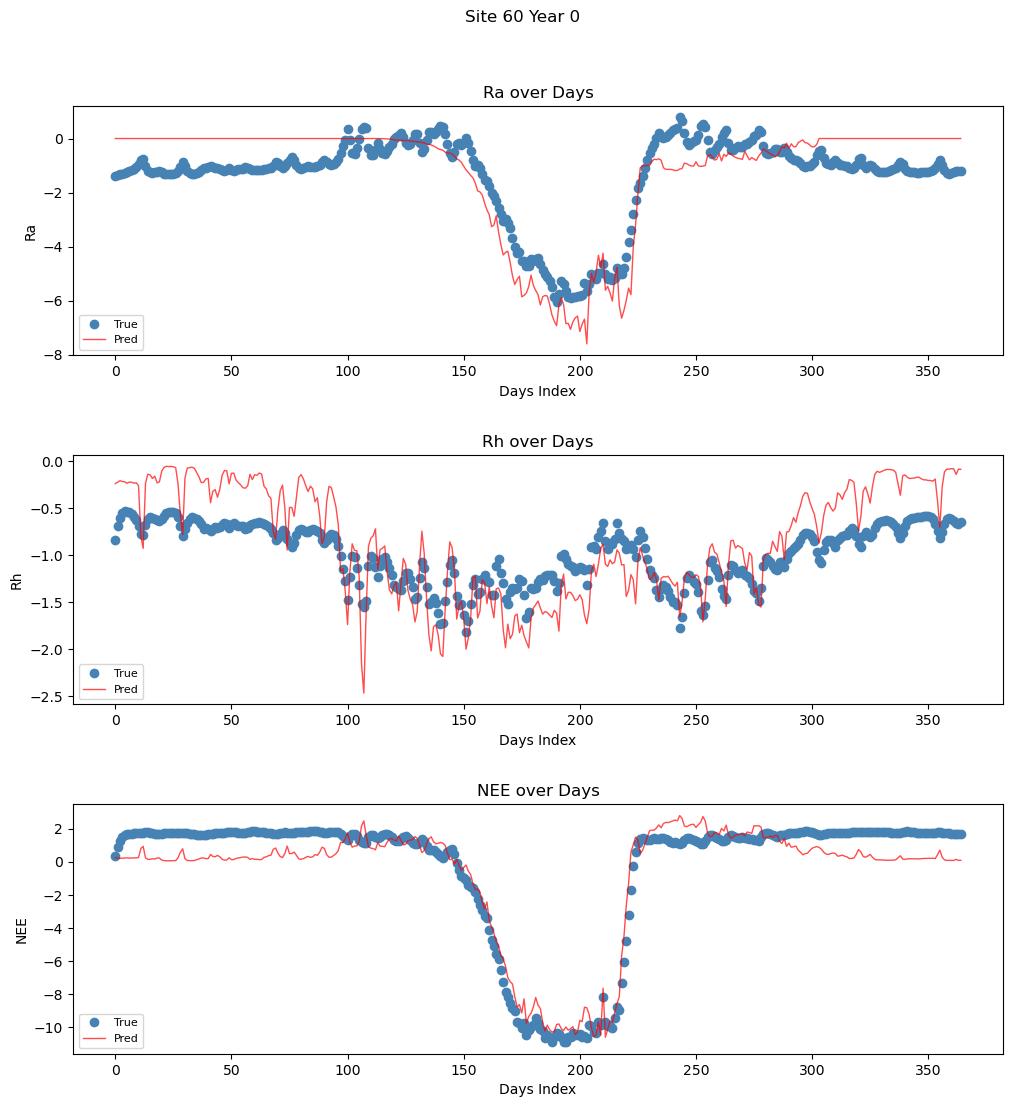

In [22]:
model.Vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=60, year=0)

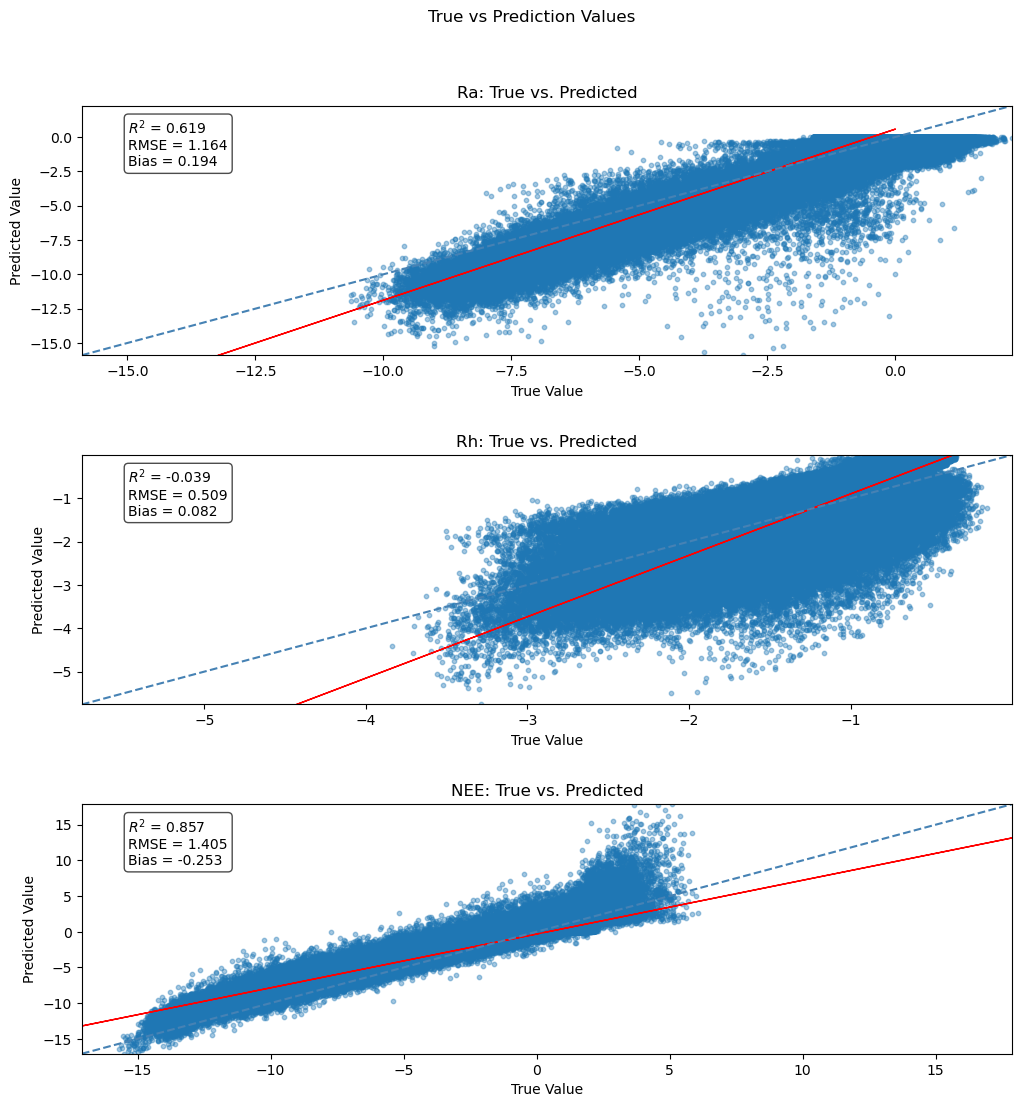

In [23]:
model.Vis_scatter_prediction_result(y_scaler, output_feature_name)